In [55]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import torch
from tqdm.auto import tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import torch.optim as optim
from joblib import Parallel, delayed
from utils import *
from methods2 import *

In [70]:
data = pd.read_csv('data/base_llm_benchmark_eval.csv')
data

,Model,Model Family,Model Size (B),Pretraining Data Size (T),FLOPs (1E21),MMLU,ARC-C,HellaSwag,Winograd,TruthfulQA,GSM8K,XWinograd,HumanEval
0,meta-llama/Llama-2-7b-hf,Llama-2,7.0,2.000,84.000,0.437961,0.530717,0.777435,0.740331,0.389802,0.144807,0.754881,0.128049
1,meta-llama/Llama-2-13b-hf,Llama-2,13.0,2.000,156.000,0.543378,0.581058,0.809699,0.766377,0.341724,0.228203,0.786798,0.182927
2,meta-llama/Llama-2-70b-hf,Llama-2,70.0,2.000,840.000,0.698321,0.673208,0.873332,0.837411,0.449235,0.540561,0.824453,0.298780
3,huggyllama/llama-7b,Llama,6.7,1.000,40.200,0.356933,0.509386,0.778132,0.714286,0.343279,0.080364,0.693204,0.128049
4,huggyllama/llama-13b,Llama,13.0,1.000,78.000,0.476106,0.561433,0.809201,0.762431,0.394789,0.075815,0.730362,0.158537
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,togethercomputer/RedPajama-INCITE-Base-3B-v1,RedPajama-INCITE-Base,3.0,0.800,14.400,0.270279,0.401877,0.647680,0.647198,0.332349,0.012889,NaN,NaN
103,togethercomputer/RedPajama-INCITE-Base-7B-v0.1,RedPajama-INCITE-Base,7.0,1.000,42.000,0.276821,0.462457,0.716292,0.673244,0.330348,0.015921,NaN,NaN
104,LLM360/Amber,Amber,7.0,1.259,52.878,0.268357,0.409556,0.737901,0.678769,0.335564,0.028052,NaN,NaN
105,Salesforce/codegen-6B-nl,Codegen,6.0,0.360,12.960,0.259345,0.423208,0.685919,0.664562,0.344705,0.021986,NaN,NaN


In [75]:
list(data['Model Family'] + " ("+ data['Model Size (B)'].astype(str) + ")")

['Llama-2 (7.0)',
 'Llama-2 (13.0)',
 'Llama-2 (70.0)',
 'Llama (6.7)',
 'Llama (13.0)',
 'Llama (32.5)',
 'Llama (65.2)',
 'Llama-3 (70.0)',
 'Llama-3 (8.0)',
 'Qwen1.5 (72.0)',
 'Qwen1.5 (32.0)',
 'Qwen1.5 (14.0)',
 'Qwen1.5 (7.0)',
 'Qwen1.5 (4.0)',
 'Qwen1.5 (1.8)',
 'Qwen1.5 (0.5)',
 'Qwen (72.0)',
 'Qwen (14.0)',
 'Qwen (7.0)',
 'Mistral (7.3)',
 'Mixtral (45.0)',
 'Yi (6.0)',
 'Yi (34.0)',
 'Gemma (7.0)',
 'Gemma (2.0)',
 'Falcon (180.0)',
 'Falcon (40.0)',
 'Falcon (7.0)',
 'Falcon (1.0)',
 'Phi (2.7)',
 'Phi (1.3)',
 'Pythia (1.0)',
 'Pythia (0.41)',
 'Pythia (6.9)',
 'Pythia (2.8)',
 'Pythia (12.0)',
 'Pythia (0.07)',
 'Pythia (1.4)',
 'Pythia (0.16)',
 'BLOOM (0.56)',
 'BLOOM (1.1)',
 'BLOOM (3.0)',
 'BLOOM (7.1)',
 'BLOOM (176.0)',
 'GPT-Neo/J (20.0)',
 'GPT-Neo/J (2.7)',
 'GPT-Neo/J (1.3)',
 'GPT-Neo/J (0.125)',
 'GPT-Neo/J (6.05)',
 'OPT (6.7)',
 'OPT (1.3)',
 'OPT (0.35)',
 'OPT (13.0)',
 'OPT (2.7)',
 'OPT (30.0)',
 'OPT (0.125)',
 'OPT (66.0)',
 'MPT (30.0)',
 'MPT (7.

In [76]:
np.unique(data['Model Family'])

array(['Amber', 'BLOOM', 'CodeLlama', 'Codegen', 'DeciLM',
       'DeepSeek-Coder', 'DeepSeek-LLM', 'DeepSeek-MoE', 'Falcon',
       'GPT-2', 'GPT-Neo/J', 'Gemma', 'InternLM2', 'Llama', 'Llama-2',
       'Llama-3', 'MPT', 'Mistral', 'Mixtral', 'OPT', 'OpenLlama',
       'OpenLlamaV2', 'Phi', 'Pythia', 'Qwen', 'Qwen1.5', 'RWKV',
       'RedPajama-INCITE-Base', 'StableLM', 'StarCoder', 'StarCoder2',
       'XGLM', 'Yi', 'Yi-200K'], dtype=object)

In [58]:
benchs_names_list = [['ARC-C','HellaSwag','Winograd','TruthfulQA','GSM8K','MMLU','XWinograd','HumanEval']] #['ARC-C','HellaSwag','Winograd','TruthfulQA','GSM8K','MMLU'],

In [59]:
pca_errors, logistic_errors, single_index_errors, logistic_basic_errors, logistic_basic_intercept_errors = {}, {}, {}, {}, {}

for cov in ['F']: #,'X','X_inter'
    pca_errors[cov], logistic_errors[cov], single_index_errors[cov], logistic_basic_errors[cov], logistic_basic_intercept_errors[cov] = [],[],[],[],[]
    
    for benchs_names in benchs_names_list:
    
        data, unique_families, avail_families = prep_data(pd.read_csv('data/base_llm_benchmark_eval.csv'), benchs_names)

        #test = run_results(avail_families[0], data, benchs_names, cov)
        results = Parallel(n_jobs=-1, verbose=True)(delayed(run_results)(test_family, data, benchs_names, cov) for test_family in avail_families)
    
        pca_error, logistic_error, single_index_error, logistic_basic_error, logistic_basic_intercept_error = zip(*results)
        
        pca_errors[cov].append(pca_error)
        logistic_errors[cov].append(logistic_error)
        single_index_errors[cov].append(single_index_error)
        logistic_basic_errors[cov].append(logistic_basic_error)
        logistic_basic_intercept_errors[cov].append(logistic_basic_intercept_error)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:  2.5min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:  2.7min finished


In [60]:
def compute_error(errors, stat='mean'):
    try:
        if stat=='mean':
            return torch.vstack([e.mean(1) for e in errors[0]]).mean(0).detach().numpy()
        else:
            return torch.vstack([e.mean(1) for e in errors[0]]).median(0).values.detach().numpy()
    except:
        if stat=='mean':
            return torch.vstack([e.mean(0) for e in errors[0]]).mean(0).detach().numpy()
        else:
            return torch.vstack([e.mean(0) for e in errors[0]]).median(0).values.detach().numpy()

Early stopping at epoch 541, best mae=0.1174139883820357
Early stopping at epoch 719, best mae=0.023166413497958893
Early stopping at epoch 1526, best mae=0.020122066578563486
Early stopping at epoch 1133, best mae=0.06405417940948861
Early stopping at epoch 564, best mae=0.09411726876488134
Early stopping at epoch 775, best mae=0.02248355848130803
Early stopping at epoch 1363, best mae=0.020259622672582012
Early stopping at epoch 905, best mae=0.06627335415776558
Early stopping at epoch 844, best mae=0.0905386215219797
Early stopping at epoch 779, best mae=0.022470013527369572
Early stopping at epoch 1188, best mae=0.020478873417890557
Early stopping at epoch 1013, best mae=0.06375799931991295
Early stopping at epoch 1057, best mae=0.09788686042847775
Early stopping at epoch 907, best mae=0.021077285537996635
Early stopping at epoch 1262, best mae=0.020319078960740953
Early stopping at epoch 1163, best mae=0.06388992204869323
Early stopping at epoch 588, best mae=0.0867283319934217
Ea

In [ ]:
for cov in ['F']: 
    for benchs_names in benchs_names_list:
        1+1

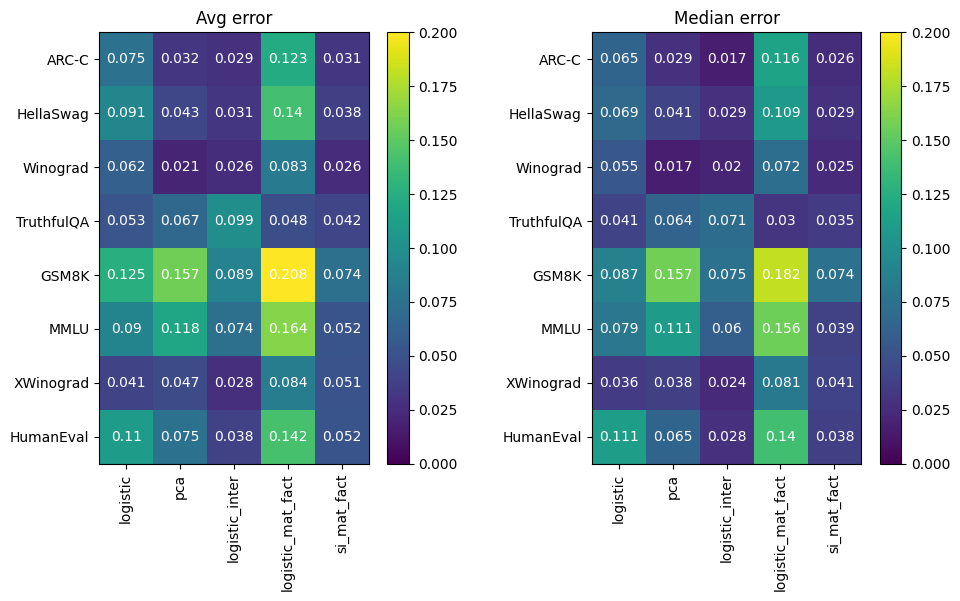

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming compute_error and benchs_names_list are defined, as well as cov, logistic_basic_errors, pca_errors, etc.

fig, axes = plt.subplots(1, 2, figsize=(10, 6))  # Create a figure with 2 subplots side by side

# Define the color range
vmin, vmax = 0, 0.2

# Plot 1: Average Error
M = np.vstack([compute_error(logistic_basic_errors[cov]),
                                compute_error(pca_errors[cov]),
                                compute_error(logistic_basic_intercept_errors[cov]),
                                compute_error(logistic_errors[cov]),
                                compute_error(single_index_errors[cov])]).T
im1 = axes[0].imshow(M, vmin=vmin, vmax=vmax)
axes[0].set_yticks(np.arange(len(benchs_names_list[0])))
axes[0].set_yticklabels(benchs_names_list[0])
axes[0].set_xticks(np.arange(5))
axes[0].set_xticklabels(['logistic', 'pca', 'logistic_inter', 'logistic_mat_fact', 'si_mat_fact'], rotation=90)
axes[0].set_title('Avg error')
# Loop over data dimensions and create text annotations.
for i in range(len(M)):
    for j in range(len(M.T)):
        text = axes[0].text(j, i, np.round(M[i, j],3),
                       ha="center", va="center", color="w")
fig.colorbar(im1, ax=axes[0])

# Plot 2: Median Error
M = np.vstack([compute_error(logistic_basic_errors[cov], stat='median'),
                                compute_error(pca_errors[cov], stat='median'),
                                compute_error(logistic_basic_intercept_errors[cov], stat='median'),
                                compute_error(logistic_errors[cov], stat='median'),
                                compute_error(single_index_errors[cov], stat='median')]).T
im2 = axes[1].imshow(M, vmin=vmin, vmax=vmax)
axes[1].set_yticks(np.arange(len(benchs_names_list[0])))
axes[1].set_yticklabels(benchs_names_list[0])
axes[1].set_xticks(np.arange(5))
axes[1].set_xticklabels(['logistic', 'pca', 'logistic_inter', 'logistic_mat_fact', 'si_mat_fact'], rotation=90)
axes[1].set_title('Median error')
# Loop over data dimensions and create text annotations.
for i in range(len(M)):
    for j in range(len(M.T)):
        text = axes[1].text(j, i, np.round(M[i, j],3),
                       ha="center", va="center", color="w")
fig.colorbar(im2, ax=axes[1])

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [15]:
torch.vstack([e.mean(1) for e in pca_errors[cov][0]]).mean(0)

RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 4 but got size 3 for tensor number 1 in the list.

In [180]:
torch.vstack([e.mean(1) for e in single_index_errors]).mean(0)

tensor([0.0288, 0.0354, 0.0235, 0.0365, 0.0856, 0.0712, 0.0506, 0.0657],
       dtype=torch.float64)

In [17]:
torch.vstack([e.mean(0) for e in pca_errors[cov][0]]).mean(0)

tensor([0.0317, 0.0430, 0.0207, 0.0665, 0.1569, 0.1181, 0.0467, 0.0752],
       dtype=torch.float64)

Early stopping at epoch 727, best mae=0.10456960733773629
Early stopping at epoch 843, best mae=0.02242864186388666
Early stopping at epoch 1253, best mae=0.020370965531799352
Early stopping at epoch 1128, best mae=0.06573530823648802
Early stopping at epoch 776, best mae=0.0965755329281875
Early stopping at epoch 997, best mae=0.021698053700395167
Early stopping at epoch 1396, best mae=0.02048581570409839
Early stopping at epoch 1136, best mae=0.06536365594100205
Early stopping at epoch 875, best mae=0.09265719686507992
Early stopping at epoch 1027, best mae=0.02150741964332891
Early stopping at epoch 1309, best mae=0.019573559905139086
Early stopping at epoch 983, best mae=0.061082993665025814
Early stopping at epoch 637, best mae=0.11154877200804872
Early stopping at epoch 1060, best mae=0.020937661240334974
Early stopping at epoch 1233, best mae=0.020416874024194537
Early stopping at epoch 1031, best mae=0.06359038592272324
Early stopping at epoch 641, best mae=0.11382004993214194


In [4]:
def single_index_model(X_train, D_train, Y_train, benchs_names, kernel, h, d, num_epochs=10000, device='cpu'):
    # Initialize parameters
    thetas = torch.nn.Parameter(torch.normal(0, 1, size=(D_train.shape[1], d), dtype=torch.float64, device=device))
    beta = torch.nn.Parameter(torch.abs(torch.normal(0, 1, size=(X_train.shape[1], d), dtype=torch.float64, device=device)))
    gamma = torch.nn.Parameter(torch.abs(torch.normal(0, 1, size=(d, len(benchs_names)), dtype=torch.float64, device=device)))

    # Initialize the Adam optimizer
    optimizer = optim.Adam([thetas, beta, gamma], lr=0.1, weight_decay=1e-10)
    
    # Lists to track the loss and MAE at each epoch
    losses = []
    maes = []

    for epoch in tqdm(range(num_epochs)):
        optimizer.zero_grad()  # Zero the gradients before the backward pass

        # Compute the loss and MAE
        loss = 0
        mae = 0
        Y_hats, Zs = [], []
        for j, _ in enumerate(benchs_names): 
            Y_hat, Z = compute_Y_hat_train(j, X_train, D_train, Y_train, beta, thetas, gamma, kernel, h, device=device)
            Y_hats.append(Y_hat)
            Zs.append(Z)
            loss += (Y_train[:, j:j+1].squeeze() - Y_hat).pow(2).mean()
            mae += torch.abs(Y_train[:, j:j+1].squeeze() - Y_hat).mean()

        epoch_loss = loss.item() / len(benchs_names)
        epoch_mae = mae.item() / len(benchs_names)
        
        print(f'h={h}, Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss}, MAE: {epoch_mae}')
        
        # Backward pass and optimization step
        loss.backward()
        optimizer.step()
        
        # Track the loss and MAE
        if np.isnan(loss.item()):
            raise ValueError("NaN encountered in loss")
        epoch_loss = loss.item() / len(benchs_names)
        losses.append(epoch_loss)

    return Zs, Y_hats, Y_train, gamma

In [5]:
Y_train = torch.tensor(np.array(data.loc[:,benchs_names]))
X_train = np.array(data.loc[:,['logT','logS']]) #
X_train = torch.tensor(X_train).double()
F_train = np.array(data.loc[:,['logF']]) #
F_train = torch.tensor(F_train).double()
D_train = torch.tensor(np.array(pd.get_dummies(np.array(data.family)))).double()

In [61]:
Zs, Y_hats, Y_train, gamma = single_index_model(F_train, D_train, Y_train, benchs_names, kernel, h, d, num_epochs=1500, device='cpu')

  0%|          | 0/1500 [00:00<?, ?it/s]

h=10, Epoch 1/1500, Loss: 0.014755720915460716, MAE: 0.09526143106190836
h=10, Epoch 2/1500, Loss: 0.012803063146980988, MAE: 0.08764715323298532
h=10, Epoch 3/1500, Loss: 0.01125408958649458, MAE: 0.08107789974695269
h=10, Epoch 4/1500, Loss: 0.010103025516485686, MAE: 0.07573689655823648
h=10, Epoch 5/1500, Loss: 0.009245554530025828, MAE: 0.07156399222029027
h=10, Epoch 6/1500, Loss: 0.008589561534464857, MAE: 0.06844780993506527
h=10, Epoch 7/1500, Loss: 0.008073762410194491, MAE: 0.06589414637142396
h=10, Epoch 8/1500, Loss: 0.0076588232902642835, MAE: 0.0637753928324093
h=10, Epoch 9/1500, Loss: 0.00731846412638165, MAE: 0.06199598140722189
h=10, Epoch 10/1500, Loss: 0.007034283633924873, MAE: 0.06050627549032827
h=10, Epoch 11/1500, Loss: 0.0067930737924372315, MAE: 0.0592424509691886
h=10, Epoch 12/1500, Loss: 0.006585367298024818, MAE: 0.05812149595766433
h=10, Epoch 13/1500, Loss: 0.006404372567081225, MAE: 0.057128098922683127
h=10, Epoch 14/1500, Loss: 0.0062450311631907455

In [65]:
x.shape

(69,)

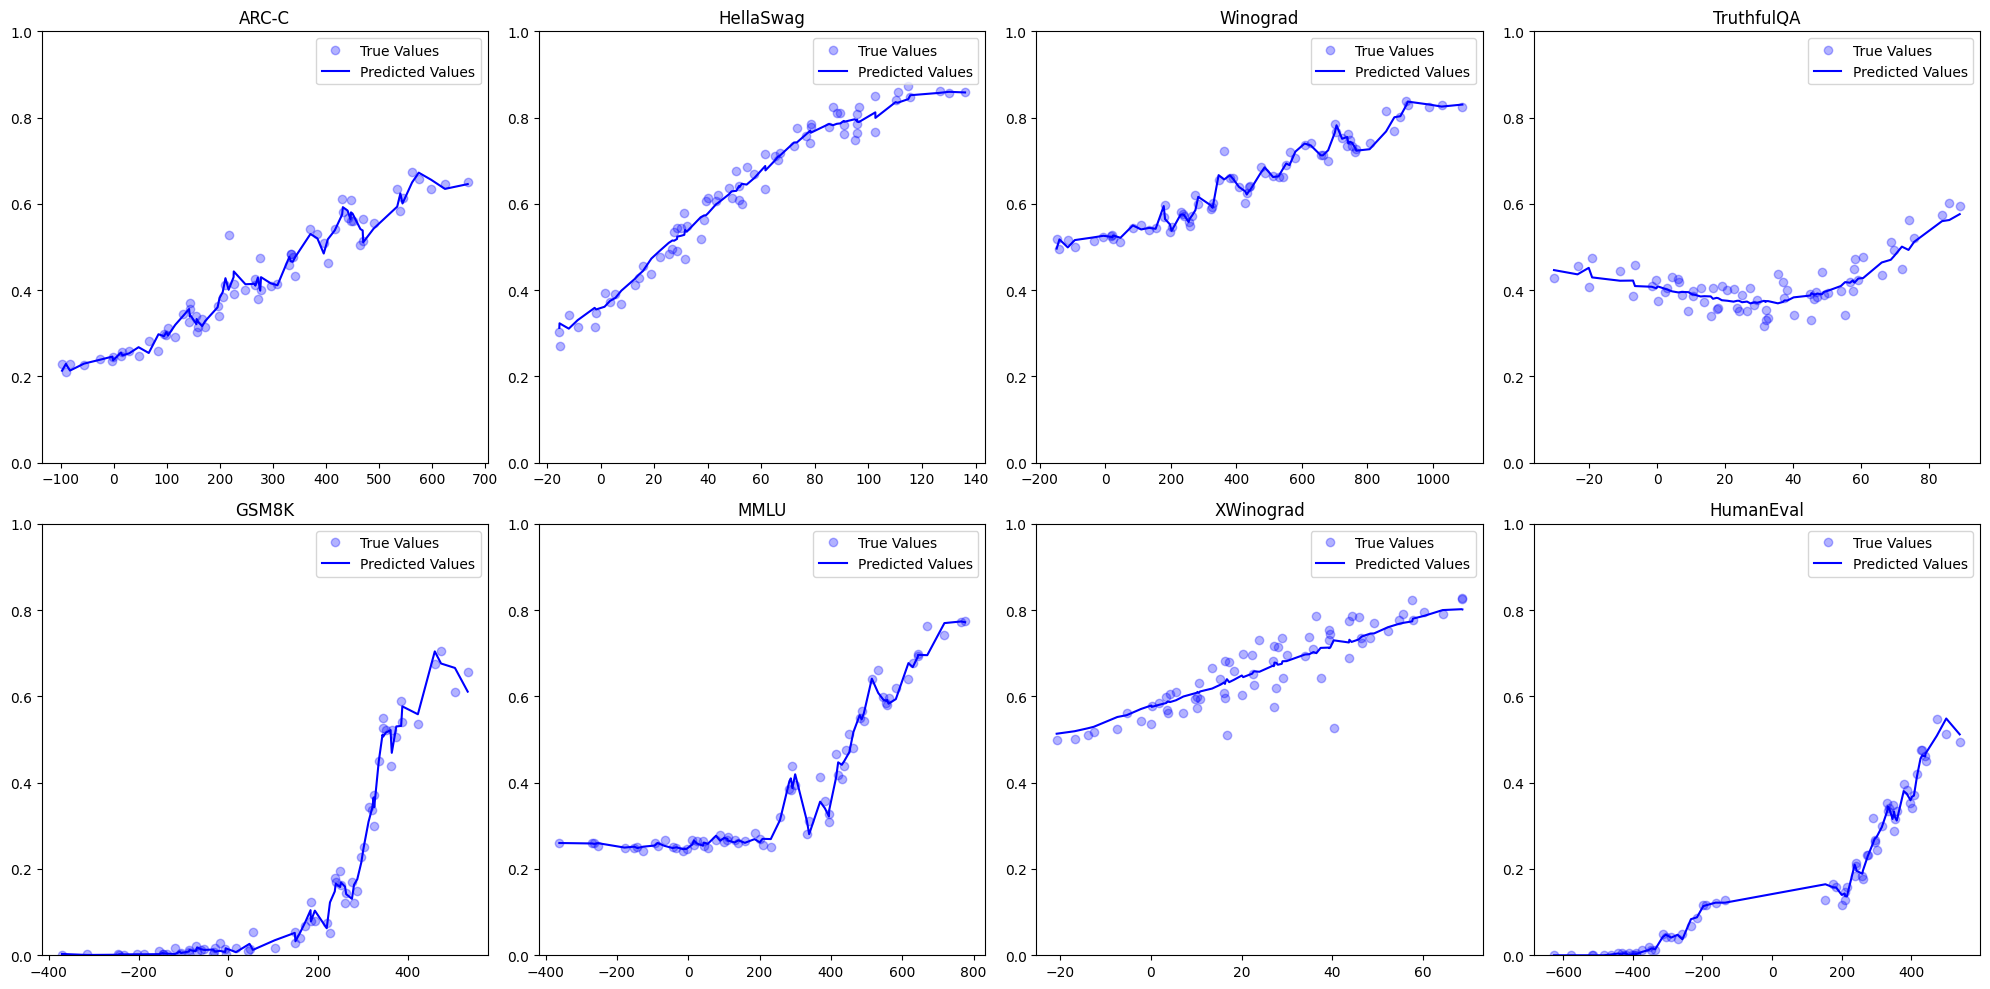

In [64]:
import matplotlib.pyplot as plt
import numpy as np

n = len(benchs_names)  # Number of subplots needed
rows = 2  # Number of rows
cols = (n + 1) // 2  # Number of columns, ensuring enough space for all plots

fig, axs = plt.subplots(rows, cols, figsize=(5 * cols, 10))  # Create a figure with n subplots

# Flatten axs array for easy indexing
axs = axs.flatten()

for j, b in enumerate(benchs_names): 
    x = Zs[j].detach().numpy().squeeze()
    y = Y_train[:, j].detach().numpy().squeeze()
    y_hat = Y_hats[j].detach().numpy().squeeze()
    
    axs[j].plot(x, y, 'bo', alpha=.3, label='True Values')
    axs[j].plot(np.sort(x), y_hat[np.argsort(x)], 'b-', label='Predicted Values')
    axs[j].set_title(b)
    axs[j].set_ylim(0, 1)
    axs[j].legend()

# Hide any unused subplots
for i in range(j + 1, len(axs)):
    fig.delaxes(axs[i])

plt.tight_layout()  # Adjust spacing to prevent overlap
plt.show()


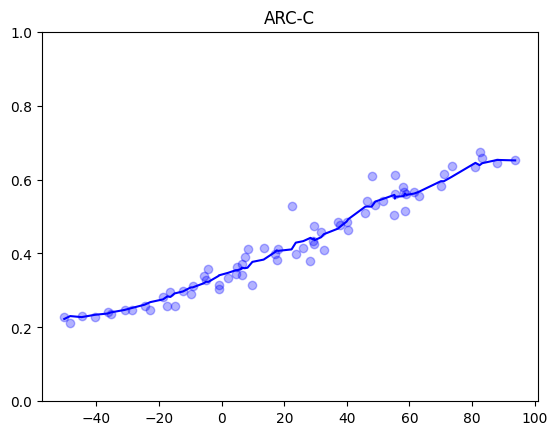

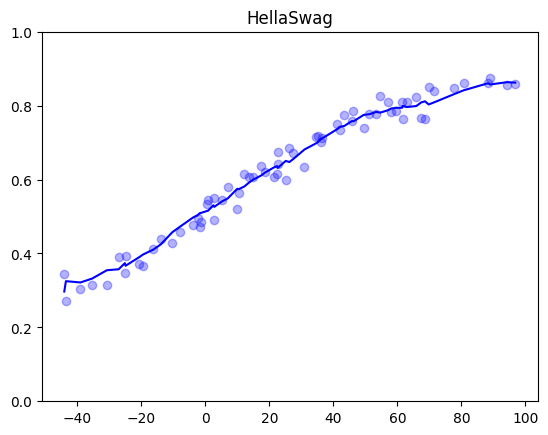

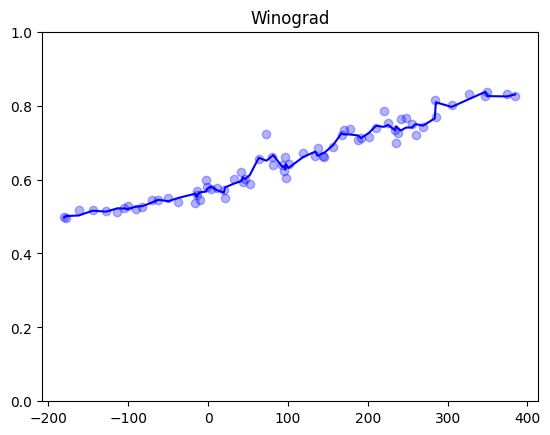

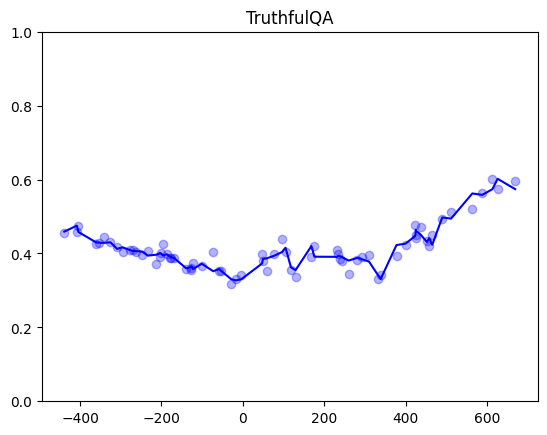

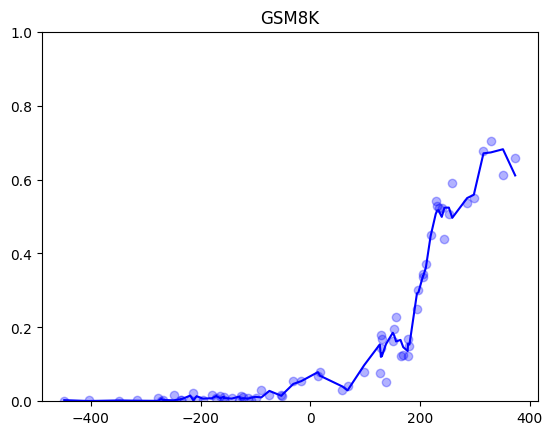

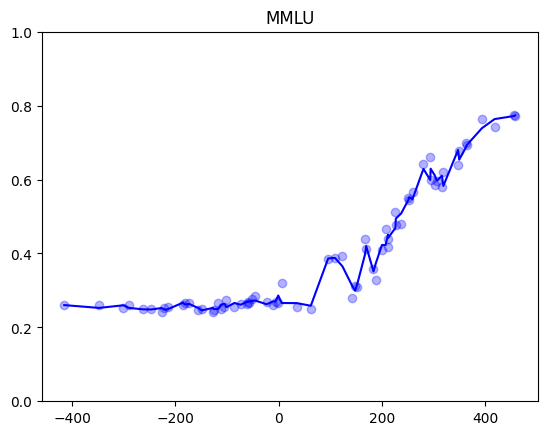

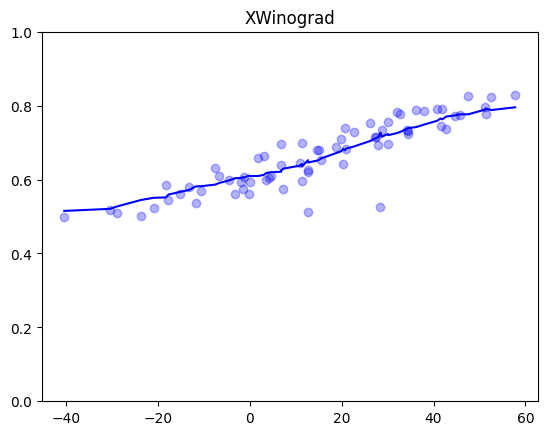

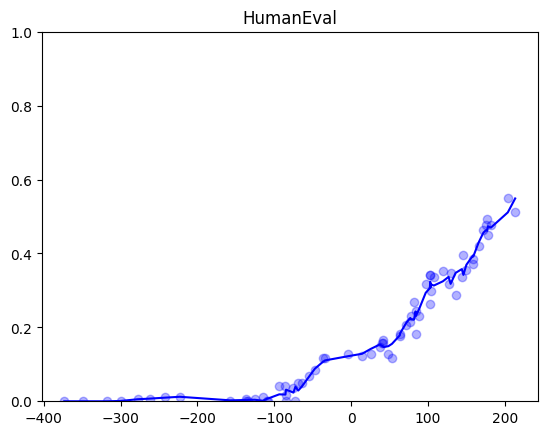

In [60]:
for j, b in enumerate(benchs_names): 
    x = Zs[j].detach().numpy().squeeze()
    y = Y_train[:,j].detach().numpy().squeeze()
    y_hat = Y_hats[j].detach().numpy().squeeze()
    plt.plot(x, y, 'bo',alpha=.3)
    plt.plot(np.sort(x), y_hat[np.argsort(x)], 'b-')
    plt.title(b)
    plt.ylim(0,1)
    plt.show()

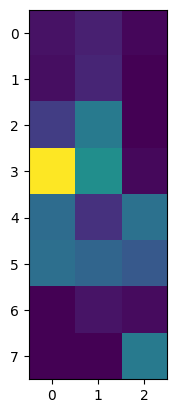

In [30]:
plt.imshow(torch.clamp(gamma, min=0).detach().numpy().T)

In [31]:
gamma

Parameter containing:
tensor([[ 1.3454,  1.0483,  4.9194, 27.0410,  9.5847,  9.8677, -1.4017, -0.6067],
        [ 2.4294,  2.7999, 10.9933, 13.3853,  3.8277,  8.8665,  1.4505, -0.7810],
        [ 0.4847, -1.1388, -1.4094,  0.6258, 10.0693,  7.5609,  0.7751, 11.0673]],
       dtype=torch.float64, requires_grad=True)

In [73]:

    
# Assume these variables are already defined
# thetas, beta, h, X_train, D_train, Y_train, mask, device

thetas = torch.nn.Parameter(torch.normal(0, .1, size=(D_train.shape[1],1), dtype=torch.float64, device=device))
beta = torch.nn.Parameter(torch.normal(0, .1, size=(X_train.shape[1],1), dtype=torch.float64, device=device))
h = torch.nn.Parameter(torch.ones((1,Y_train.shape[1],1), dtype=torch.float64, device=device))

# Initialize the Adam optimizer
optimizer = optim.Adam([thetas, beta, h], lr=.5)

# Number of epochs
num_epochs = 1000

# Lists to track the loss and MAE at each epoch
losses = []
maes = []

for epoch in range(num_epochs):
    optimizer.zero_grad()  # Zero the gradients before backward pass
    
    # Forward pass
    Z = (X_train @ beta) + (D_train @ thetas)
    Z = Z @ torch.ones((1, Y_train.shape[1])).double()
    K = k(Z[:, :, None] - Z.T[None, :, :], torch.exp(h))
    mask = torch.ones(K.shape, dtype=bool)
    for i in range(mask.shape[0]):
        mask[i,:,i] = False
        
    # Compute the loss and MAE
    loss = 0
    mae = 0
    for i in range(mask.shape[0]):
        Y_hat = ((((K * Y_train.T[None, :, :])[i]) * mask[i]).sum(1) / 
                 ((K * Y_train.T[None, :, :])[i]).sum(1))
        loss += (Y_train[i] - Y_hat).pow(2).mean()
        mae += torch.abs(Y_train[i] - Y_hat).mean()
    
    # Backward pass and optimization step
    loss.backward()
    optimizer.step()
    
    # Track the loss and MAE
    losses.append(loss.item()/ Y_train.shape[0])
    maes.append(mae.item() / Y_train.shape[0])  # Average MAE across all elements
    
    # Print the loss and MAE for the current epoch
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, MAE: {maes[-1]}')
    print(Y_hat)
# losses and maes now contain the loss and MAE values at each epoch


Epoch 1/1000, Loss: 31.68025443336958, MAE: 0.582746094278136
Epoch 2/1000, Loss: 24.12819249933432, MAE: 0.4908192789908531
Epoch 3/1000, Loss: 13.720918869302917, MAE: 0.3514676347027345
Epoch 4/1000, Loss: 10.570122562519716, MAE: 0.29443737442952683
Epoch 5/1000, Loss: 13.609960674585285, MAE: 0.34560780288361403
Epoch 6/1000, Loss: 14.69351448930025, MAE: 0.35967861692536557
Epoch 7/1000, Loss: 14.543832134540036, MAE: 0.3603570525786836
Epoch 8/1000, Loss: 15.724716099670342, MAE: 0.38065515566303065
Epoch 9/1000, Loss: 14.974403607715814, MAE: 0.3691917710091143
Epoch 10/1000, Loss: 14.503747248601242, MAE: 0.3555769543979791
Epoch 11/1000, Loss: 14.27162569950821, MAE: 0.3547875682384643
Epoch 12/1000, Loss: 14.574989245567359, MAE: 0.35792538979542254
Epoch 13/1000, Loss: 14.65192641905274, MAE: 0.3587608252788466
Epoch 14/1000, Loss: 14.123276144909225, MAE: 0.34785675306889086
Epoch 15/1000, Loss: 12.348927740982747, MAE: 0.3180988908099025
Epoch 16/1000, Loss: 13.0406368589

KeyboardInterrupt: 

In [62]:
h

Parameter containing:
tensor([[[nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
  

In [44]:
Y_train.shape

torch.Size([83, 62])

In [45]:
Y_train[i].shape, Y_hat.shape

(torch.Size([62]), torch.Size([62]))

In [52]:
torch.abs(Y_train[i] - Y_hat).mean()

tensor(0.1723, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [53]:
Y_hat

tensor([0.6430, 0.6734, 0.6584, 0.7131, 0.7043, 0.6579, 0.6455, 0.6385, 0.6579,
        0.6474, 0.6441, 0.6644, 0.6545, 0.6938, 0.6557, 0.6313, 0.6637, 0.6492,
        0.6540, 0.6582, 0.6502, 0.6744, 0.6388, 0.6513, 0.6479, 0.6503, 0.6609,
        0.6477, 0.6528, 0.6555, 0.6880, 0.6513, 0.6778, 0.6524, 0.6480, 0.6493,
        0.6524, 0.6515, 0.6468, 0.6510, 0.6421, 0.6434, 0.6515, 0.6540, 0.6519,
        0.6476, 0.6534, 0.6561, 0.6084, 0.6496, 0.6485, 0.6498, 0.6512, 0.6399,
        0.6478, 0.6420, 0.6487, 0.6623, 0.6568, 0.6542, 0.6375, 0.6552],
       dtype=torch.float64, grad_fn=<DivBackward0>)

In [54]:
Y_train[i]

tensor([0.6578, 0.8206, 0.8287, 0.4260, 0.3487, 0.4200, 0.7333, 0.8947, 0.7800,
        0.8113, 0.8819, 0.4700, 0.6300, 0.4000, 0.7110, 0.5490, 0.8000, 0.7745,
        0.5614, 0.7724, 0.6455, 0.5159, 0.5700, 0.8968, 0.6502, 0.8200, 0.8485,
        0.9293, 0.9741, 0.7821, 0.3815, 0.8403, 0.4636, 0.9211, 0.6713, 0.9069,
        0.9072, 0.7937, 0.8626, 0.9174, 0.8889, 0.8834, 0.5804, 0.8932, 0.9402,
        0.8800, 0.9029, 0.8035, 0.6760, 0.8464, 0.8199, 0.8364, 0.6135, 0.5913,
        0.8088, 0.8203, 0.7273, 0.8204, 0.8806, 0.9200, 0.5723, 0.8772],
       dtype=torch.float64)

In [43]:
h.shape

torch.Size([2])

In [6]:
def sigmoid(z, use_torch=True):
    if use_torch:
        return torch.nn.Sigmoid()(z)
    else:
        return 1/(1+np.exp(-z))

In [7]:
d = 10

epochs=100
tol=1e-8

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression


In [8]:
data = data.dropna(how='any')
unique_families, counts_families = np.unique(data.family, return_counts=True)
avail_families = unique_families[counts_families>=2]

In [12]:
preds = []
preds_baseline = []
preds_baseline2 = []
preds_rf = []
ys = []

for test_family in tqdm(avail_families):
    
    data_train = data.loc[data.family != test_family]
    data_test = data.loc[data.family == test_family]
    data_train = pd.concat((data_test.iloc[:1],data_train), axis=0).reset_index(drop=True)
    data_test = data_test.iloc[1:].reset_index(drop=True)
    
    ###
    Y_train = torch.tensor(logit(np.array(data_train.loc[:,['ARC-C','HellaSwag','Winograd','TruthfulQA','GSM8K']+mmlu_subs])))
    X_train = np.array(data_train.loc[:,['logT','logS','logS*logT']])
    X_train = torch.tensor(np.hstack((np.ones(X_train.shape[0])[:,None], X_train))).double()
    Y_test = torch.tensor(logit(np.array(data_test.loc[:,['ARC-C','HellaSwag','Winograd','TruthfulQA','GSM8K']+mmlu_subs])))
    X_test = np.array(data_test.loc[:,['logT','logS','logS*logT']])
    X_test = torch.tensor(np.hstack((np.ones(X_test.shape[0])[:,None], X_test))).double()
    D_train = torch.tensor(np.array(pd.get_dummies(np.array(data_train.family)))).double()
    D_test = torch.tensor(np.vstack([D_train[0,:].numpy() for _ in range(Y_test.shape[0])])).double()

    X2_train = torch.hstack((torch.tensor(np.array(data_train.loc[:,['logT','logS','logS*logT']])), D_train)) #torch.tensor(np.array(data_train.loc[:,['logF']]))
    X2_test = torch.hstack((torch.tensor(np.array(data_test.loc[:,['logT','logS','logS*logT']])), D_test)) #torch.tensor(np.array(data_train.loc[:,['logF']]))

    ###
    thetas = torch.nn.Parameter(torch.normal(0, .5, size=(D_train.shape[1],d), dtype=torch.float64, device=device))
    beta = torch.nn.Parameter(torch.normal(0, .5, size=(X_train.shape[1]+d,Y_train.shape[1]), dtype=torch.float64, device=device))
    beta_baseline = torch.nn.Parameter(torch.normal(0, .5, size=(X_train.shape[1],Y_train.shape[1]), dtype=torch.float64, device=device))
    beta_baseline2 = torch.nn.Parameter(torch.normal(0, .5, size=(X2_train.shape[1],Y_train.shape[1]), dtype=torch.float64, device=device))
    
    ###
    optimizer = torch.optim.LBFGS([beta,thetas], lr=.1, line_search_fn='strong_wolfe')
    losses = []
    for epoch in range(epochs):
        def closure():
            optimizer.zero_grad()
            loss = (((X_train@beta[d:] + (D_train@thetas)@beta[:d])-Y_train)**2).mean()
            loss.backward()
            return loss
        loss = optimizer.step(closure)
        abs_loss = (((X_train@beta[d:] + (D_train@thetas)@beta[:d])-Y_train).abs()).mean()
        losses.append(abs_loss.item())
    
        if epoch>=1:
            if losses[-2]-losses[-1]<=tol:
                break

    ###
    optimizer = torch.optim.LBFGS([beta_baseline], lr=.1, line_search_fn='strong_wolfe')
    losses = []
    for epoch in range(epochs):
        def closure():
            optimizer.zero_grad()
            loss = (((X_train@beta_baseline)-Y_train)**2).mean()
            loss.backward()
            return loss
        loss = optimizer.step(closure)
        abs_loss = (((X_train@beta_baseline)-Y_train).abs()).mean()
        losses.append(abs_loss.item())
    
        if epoch>=1:
            if losses[-2]-losses[-1]<=tol:
                break

    ###
    optimizer = torch.optim.LBFGS([beta_baseline2], lr=.1, line_search_fn='strong_wolfe')
    losses = []
    for epoch in range(epochs):
        def closure():
            optimizer.zero_grad()
            loss = (((X2_train@beta_baseline2)-Y_train)**2).mean()
            loss.backward()
            return loss
        loss = optimizer.step(closure)
        abs_loss = (((X2_train@beta_baseline2)-Y_train).abs()).mean()
        losses.append(abs_loss.item())
    
        if epoch>=1:
            if losses[-2]-losses[-1]<=tol:
                break

    preds.append(sigmoid(((X_test@beta[d:] + (D_test@thetas)@beta[:d]))).detach().numpy())
    preds_baseline.append(sigmoid(((X_test@beta_baseline))).detach().numpy())
    preds_baseline2.append(sigmoid(((X2_test@beta_baseline2))).detach().numpy())

    ###
    cols = [[0],[1],[2],[3],[4],list(range(Y_train.shape[1]))[5:]]
    pred_rf = np.zeros((Y_test.shape[0],Y_train.shape[1]))
    for col in cols:
        regr = RidgeCV(alphas=np.linspace(1e-5,10,20)) #RandomForestRegressor(n_estimators=1000, max_features='sqrt', random_state=0)
        regr.fit(Y_train[:,:4], Y_train[:,col].squeeze()) #np.delete(sigmoid(Y_train), col, axis=1), 
        pred_rf[:,col] = sigmoid(regr.predict(logit(preds_baseline2[-1])[:,:4]).reshape(-1,len(col)), use_torch=False) #np.delete(logit(preds_baseline2[-1]), col, axis=1)
        #pred_rf[:,[i for i in range(Y_train.shape[1]) if i not in col]] = preds_baseline2[-1][:,[i for i in range(Y_train.shape[1]) if i not in col]]
    preds_rf.append(pred_rf)
        
    ys.append(sigmoid(Y_test[:,:]).numpy())

  0%|          | 0/22 [00:00<?, ?it/s]

In [13]:
np.mean(np.abs(np.vstack(preds)[:,:5]-np.vstack(ys)[:,:5]), axis=0)

array([0.03484117, 0.04405401, 0.02929322, 0.04246133, 0.05998127])

In [14]:
np.mean(np.abs(np.vstack(preds_baseline)[:,:5]-np.vstack(ys)[:,:5]), axis=0)

array([0.05159197, 0.06620617, 0.04097824, 0.03716612, 0.0777711 ])

In [15]:
np.mean(np.abs(np.vstack(preds_baseline2)[:,:5]-np.vstack(ys)[:,:5]), axis=0)

array([0.02932462, 0.046043  , 0.02988084, 0.04813632, 0.06037273])

In [16]:
np.mean(np.abs(np.vstack(preds_rf)[:,:5]-np.vstack(ys)[:,:5]), axis=0)

array([0.02936353, 0.04601182, 0.02983732, 0.04809264, 0.09816683])

In [17]:
np.median(np.abs(np.vstack(preds)[:,:5]-np.vstack(ys)[:,:5]), axis=0)

array([0.02349686, 0.029052  , 0.02275559, 0.03488756, 0.01179707])

In [18]:
np.median(np.abs(np.vstack(preds_baseline)[:,:5]-np.vstack(ys)[:,:5]), axis=0)

array([0.03058035, 0.04576952, 0.02934638, 0.02100441, 0.02115813])

In [19]:
np.median(np.abs(np.vstack(preds_baseline2)[:,:5]-np.vstack(ys)[:,:5]), axis=0)

array([0.01784383, 0.03382038, 0.02087774, 0.04381062, 0.01115699])

In [20]:
np.median(np.abs(np.vstack(preds_rf)[:,:5]-np.vstack(ys)[:,:5]), axis=0)

array([0.01797291, 0.03410773, 0.02103038, 0.04392663, 0.02196258])

In [21]:
np.mean(np.abs(np.vstack(preds)[:,5:].mean(1)-np.vstack(ys)[:,5:].mean(1)))

0.05534097995038255

In [22]:
np.mean(np.abs(np.vstack(preds_baseline)[:,5:].mean(1)-np.vstack(ys)[:,5:].mean(1)))

0.07484974350315568

In [23]:
np.mean(np.abs(np.vstack(preds_baseline2)[:,5:].mean(1)-np.vstack(ys)[:,5:].mean(1)))

0.05556360186100937

In [24]:
np.mean(np.abs(np.vstack(preds_rf)[:,5:].mean(1)-np.vstack(ys)[:,5:].mean(1)), axis=0)

0.07491827144189878

In [21]:
np.median(np.abs(np.vstack(preds)[:,5:].mean(1)-np.vstack(ys)[:,5:].mean(1)))

0.04061560915989798

In [22]:
np.median(np.abs(np.vstack(preds_baseline)[:,5:].mean(1)-np.vstack(ys)[:,5:].mean(1)))

0.07036375818993645

In [23]:
np.median(np.abs(np.vstack(preds_baseline2)[:,5:].mean(1)-np.vstack(ys)[:,5:].mean(1)))

0.04036635411883588